# Approche Auto encodeur du débruitage d'images

## Chargement du fichier de données

In [ ]:
import gc
import tensorflow as tf
import torch
from google.colab import files
#


gc.collect()
#Pour l'utilisation du GPU, vous pouvez également essayer :
!nvidia-smi
#Si vous utilisez TensorFlow :
tf.keras.backend.clear_session()
#Si vous utilisez PyTorch :
torch.cuda.empty_cache()


uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

## Dézipper le données

In [ ]:

import zipfile
uploaded = "/content/flickr_images.zip"
if uploaded.endswith('.zip'):
    zip_ref = zipfile.ZipFile(uploaded, 'r')
    zip_ref.extractall('/content/')
    zip_ref.close()
    print(f"File '{uploaded}' unzipped successfully to /content/")
else:
    print(f"File '{uploaded}' is not a zip file.")

File '/content/flickr_images.zip' unzipped successfully to /content/


## Préparation des données

Processing images for /content/data/div2k_noisy_dataset/train/clean: 100%|██████████| 1818/1818 [00:42<00:00, 43.27it/s]
Processing images for /content/data/div2k_noisy_dataset/val/clean: 100%|██████████| 227/227 [00:05<00:00, 43.55it/s]
Processing images for /content/data/div2k_noisy_dataset/test/clean: 100%|██████████| 227/227 [00:05<00:00, 43.05it/s]


Training images: 1818
Validation images: 227
Test images: 227


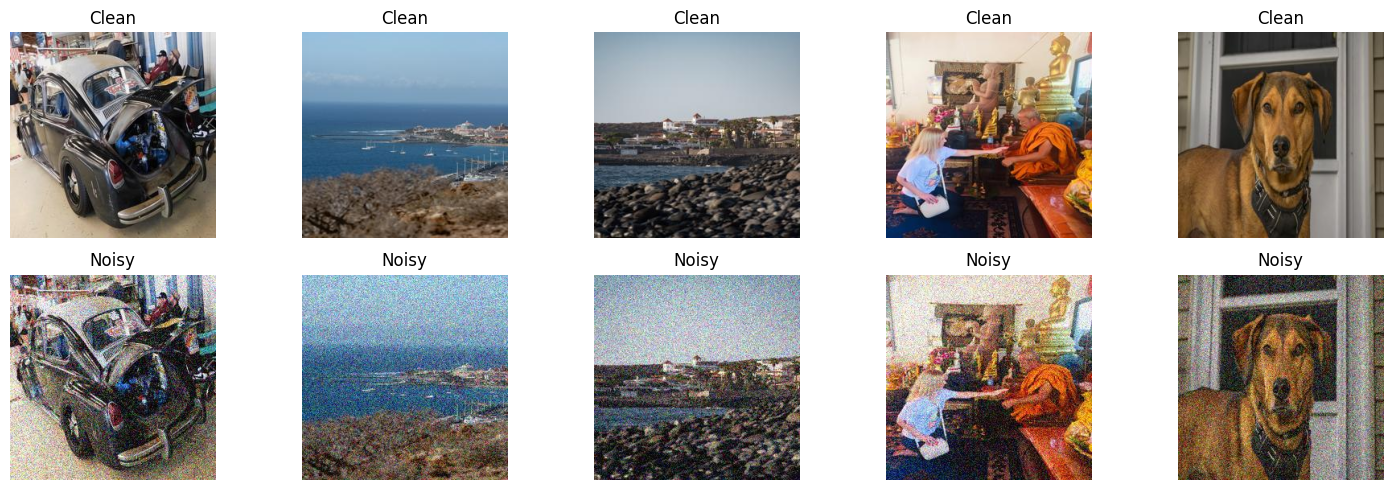

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
IMAGE_SIZE = (256, 256)
TRAIN_SIZE = 1818
VAL_SIZE = 227
TEST_SIZE = 227

# Chemins d’accès à l’organisation des ensembles de données
BASE_DIR = "/content/data/div2k_noisy_dataset"
DIRS = {
    "train_clean": os.path.join(BASE_DIR, "train/clean"),
    "train_noisy": os.path.join(BASE_DIR, "train/noisy"),
    "val_clean": os.path.join(BASE_DIR, "val/clean"),
    "val_noisy": os.path.join(BASE_DIR, "val/noisy"),
    "test_clean": os.path.join(BASE_DIR, "test/clean"),
    "test_noisy": os.path.join(BASE_DIR, "test/noisy"),
}

# Function pour Créer des répertoires
def create_directories(dirs):
    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)

# Ajout de bruit avec des niveaux aléatoires
def prepare_images_with_varied_noise(base_images, num_images, clean_dir, noisy_dir, noise_stddev_range):
    selected_images = np.random.choice(base_images, num_images, replace=False)
    for img_path in tqdm(selected_images, desc=f"Processing images for {clean_dir}"):
        img = Image.open(img_path).convert("RGB").resize(IMAGE_SIZE)
        clean_img = np.asarray(img, dtype=np.float32) / 255.0

        # Niveau de bruit aléatoire
        noise_stddev = np.random.uniform(noise_stddev_range[0], noise_stddev_range[1])
        noise = np.random.normal(0, noise_stddev / 255.0, clean_img.shape)
        noisy_img = np.clip(clean_img + noise, 0.0, 1.0)

        # Sauvegarde
        clean_file_path = os.path.join(clean_dir, os.path.basename(img_path))
        noisy_file_path = os.path.join(noisy_dir, os.path.basename(img_path))
        Image.fromarray((clean_img * 255).astype(np.uint8)).save(clean_file_path)
        Image.fromarray((noisy_img * 255).astype(np.uint8)).save(noisy_file_path)


# Main process
def process_dataset():
    div2k_path = "/content/flickr_images"
    all_images = [os.path.join(div2k_path, f) for f in os.listdir(div2k_path) if f.endswith(".jpg")]

    # Split dataset
    train_images, temp_images = train_test_split(all_images, train_size=TRAIN_SIZE)
    val_images, test_images = train_test_split(temp_images, test_size=TEST_SIZE, train_size=VAL_SIZE)

    # Créer des répertoires
    create_directories(DIRS)

    # Traiter et enregistrer des images
    prepare_images_with_varied_noise(train_images, TRAIN_SIZE, DIRS["train_clean"], DIRS["train_noisy"], (10, 50))
    prepare_images_with_varied_noise(val_images, VAL_SIZE, DIRS["val_clean"], DIRS["val_noisy"], (10, 50))
    prepare_images_with_varied_noise(test_images, TEST_SIZE, DIRS["test_clean"], DIRS["test_noisy"], (10, 50))




    print(f"Training images: {len(os.listdir(DIRS['train_clean']))}")
    print(f"Validation images: {len(os.listdir(DIRS['val_clean']))}")
    print(f"Test images: {len(os.listdir(DIRS['test_clean']))}")

# Exécutez le processus
process_dataset()


def display_examples(clean_dir, noisy_dir, num_examples=5):
    clean_images = os.listdir(clean_dir)[:num_examples]
    noisy_images = os.listdir(noisy_dir)[:num_examples]

    plt.figure(figsize=(15, 5))
    for i, (clean_img, noisy_img) in enumerate(zip(clean_images, noisy_images)):
        clean_path = os.path.join(clean_dir, clean_img)
        noisy_path = os.path.join(noisy_dir, noisy_img)

        clean = np.array(Image.open(clean_path))
        noisy = np.array(Image.open(noisy_path))

        plt.subplot(2, num_examples, i + 1)
        plt.imshow(clean)
        plt.title("Clean")
        plt.axis("off")

        plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(noisy)
        plt.title("Noisy")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Afficher des exemples de l'ensemble de formation
display_examples(DIRS["train_clean"], DIRS["train_noisy"])


## Définition du modèle

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Définition du modèle autoencodeur optimisé
model = models.Sequential()

# 1. Input Layer
model.add(layers.InputLayer(input_shape=(256, 256, 3)))

# 2. Encodeur : 3 niveaux avec convolutions stridées
filters = 64
for _ in range(3):
    model.add(layers.Conv2D(filters, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    filters *= 2  # Double les filtres à chaque niveau

# 3. Goulot d'étranglement
model.add(layers.Conv2D(filters, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())

# 4. Décodeur : 3 niveaux avec convolutions transposées
for _ in range(3):
    filters //= 2  # Divise les filtres par deux à chaque niveau
    model.add(layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())


# 5. Couche de sortie
model.add(layers.Conv2D(3, (1, 1), activation='sigmoid', padding='same'))

# Résumé du modèle
model.summary()


# Définir la taille de l'image
IMAGE_SIZE = (256, 256)  # 256x256 images



# Définir la fonction SSIM
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Définir PSNR
@tf.keras.utils.register_keras_serializable()
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.5 * mse + 0.5 * ssim_loss


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=combined_loss,
    metrics=[psnr_metric, ssim_metric]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 64, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,658,307 (17.77 MB)

 Trainable params: 4,653,699 (17.75 MB)

 Non-trainable params: 4,608 (18.00 KB)

## Préparation et lancement de l'entraînement

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - loss: 0.4068 - psnr_metric: 13.7757 - ssim_metric: 0.2410 - val_loss: 0.3658 - val_psnr_metric: 11.8916 - val_ssim_metric: 0.3382
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.2189 - psnr_metric: 18.3028 - ssim_metric: 0.5792 - val_loss: 0.3435 - val_psnr_metric: 12.7366 - val_ssim_metric: 0.3700
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.1870 - psnr_metric: 19.0833 - ssim_metric: 0.6403 - val_loss: 0.2867 - val_psnr_metric: 15.2778 - val_ssim_metric: 0.4580
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.1776 - psnr_metric: 19.0832 - ssim_metric: 0.6592 - val_loss: 0.1916 - val_psnr_metric: 18.5829 - val_ssim_metric: 0.6326
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.1665 - psnr_metric: 19.3960 - ssim_metric: 0.6802 - val_loss: 0.1669 - val_psnr_metric: 19.9255 - val_ssim_metric: 0.6785
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.1601 - psnr_metri

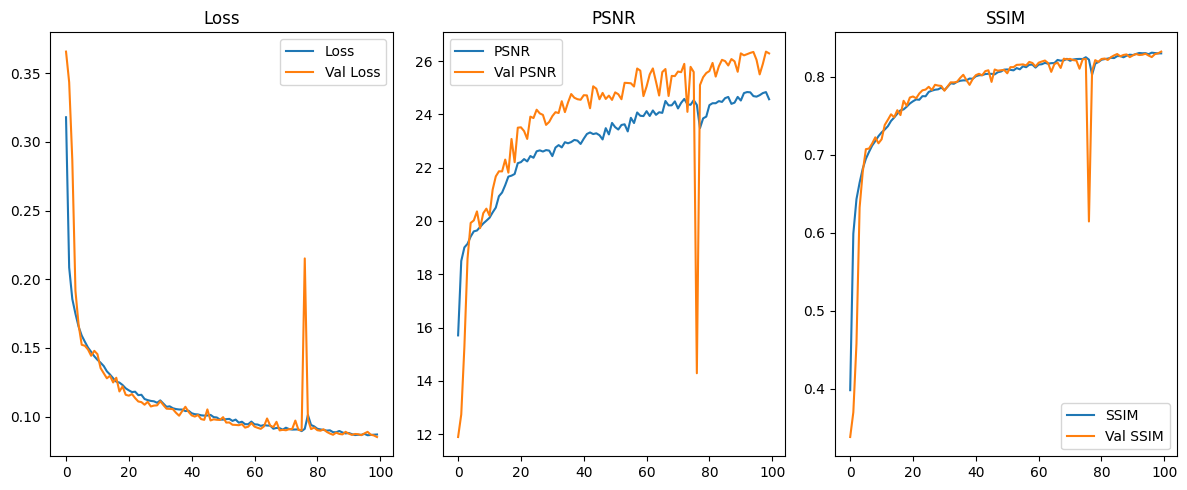

In [ ]:
# Création d'un générateur de données
class ImagePairGenerator(Sequence):
    def __init__(self, noisy_dir, clean_dir, batch_size, target_size):
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.noisy_images = sorted(os.listdir(noisy_dir))
        self.clean_images = sorted(os.listdir(clean_dir))

        # Assurez-vous que les deux répertoires ont le même nombre d'images
        min_len = min(len(self.noisy_images), len(self.clean_images))
        self.noisy_images = self.noisy_images[:min_len]
        self.clean_images = self.clean_images[:min_len]

        self.indexes = np.arange(len(self.noisy_images))

    def __len__(self):
        return int(np.floor(len(self.noisy_images) / self.batch_size))

    def on_epoch_end(self):
        'Reorganize the indexes after each epoch'
        np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Assurez-vous que les batch_index sont dans la plage valide
        batch_indexes = self.indexes[index * self.batch_size : min((index + 1) * self.batch_size, len(self.noisy_images))]

        noisy_batch = []
        clean_batch = []

        for i in batch_indexes:
            noisy_img_path = os.path.join(self.noisy_dir, self.noisy_images[i])
            clean_img_path = os.path.join(self.clean_dir, self.clean_images[i])

            noisy_img = load_img(noisy_img_path, target_size=self.target_size)
            clean_img = load_img(clean_img_path, target_size=self.target_size)

            noisy_batch.append(img_to_array(noisy_img) / 255.0)  # Normalisation
            clean_batch.append(img_to_array(clean_img) / 255.0)  # Normalisation

        return np.array(noisy_batch), np.array(clean_batch)

# Créer un générateur pour l'entraînement et la validation
train_gen = ImagePairGenerator(
    noisy_dir=BASE_DIR + '/train/noisy',
    clean_dir=BASE_DIR + '/train/clean',
    batch_size=16,
    target_size=IMAGE_SIZE
)

val_gen = ImagePairGenerator(
    noisy_dir=BASE_DIR + '/val/noisy',
    clean_dir=BASE_DIR + '/val/clean',
    batch_size=16,
    target_size=IMAGE_SIZE
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_denoising01.keras", save_best_only=True, monitor="val_loss", mode="min"),
    tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
]


# Entraînement avec le callback
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# Get the best loss and metrics
best_train_loss = min(history.history['loss'])
best_val_loss = min(history.history['val_loss'])
best_train_psnr = max(history.history['psnr_metric'])
best_val_psnr = max(history.history['val_psnr_metric'])
best_train_ssim = max(history.history['ssim_metric'])
best_val_ssim = max(history.history['val_ssim_metric'])

# Print the best values
print(f"Best Training Loss: {best_train_loss:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Training PSNR: {best_train_psnr:.4f}")
print(f"Best Validation PSNR: {best_val_psnr:.4f}")
print(f"Best Training SSIM: {best_train_ssim:.4f}")
print(f"Best Validation SSIM: {best_val_ssim:.4f}")

# Affichage des courbes de perte, PSNR et SSIM
plt.figure(figsize=(12, 5))

# Courbes de la perte
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

# Courbes de PSNR
plt.subplot(1, 3, 2)
plt.plot(history.history['psnr_metric'], label='PSNR')
plt.plot(history.history['val_psnr_metric'], label='Val PSNR')
plt.title('PSNR')
plt.legend()

# Courbes de SSIM
plt.subplot(1, 3, 3)
plt.plot(history.history['ssim_metric'], label='SSIM')
plt.plot(history.history['val_ssim_metric'], label='Val SSIM')
plt.title('SSIM')
plt.legend()

plt.tight_layout()
plt.show()


## Charger le modèle déjà entraîné

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

# Chargement du modèle sauvegardé
# Charger le modèle en spécifiant les objets personnalisés
# Charger le modèle en spécifiant les objets personnalisés
autoencoder = load_model(
    '/content/model_denoising01.keras',
    custom_objects={
        'combined_loss': combined_loss,
        'psnr_metric': psnr_metric,
        'ssim_metric': ssim_metric
    }
)

## Tester le modèle

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0834 - psnr_metric: 26.3787 - ssim_metric: 0.8359
Test Loss: 0.08652622997760773, Test PSNR: 26.18734359741211, Test SSIM: 0.8298161625862122
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


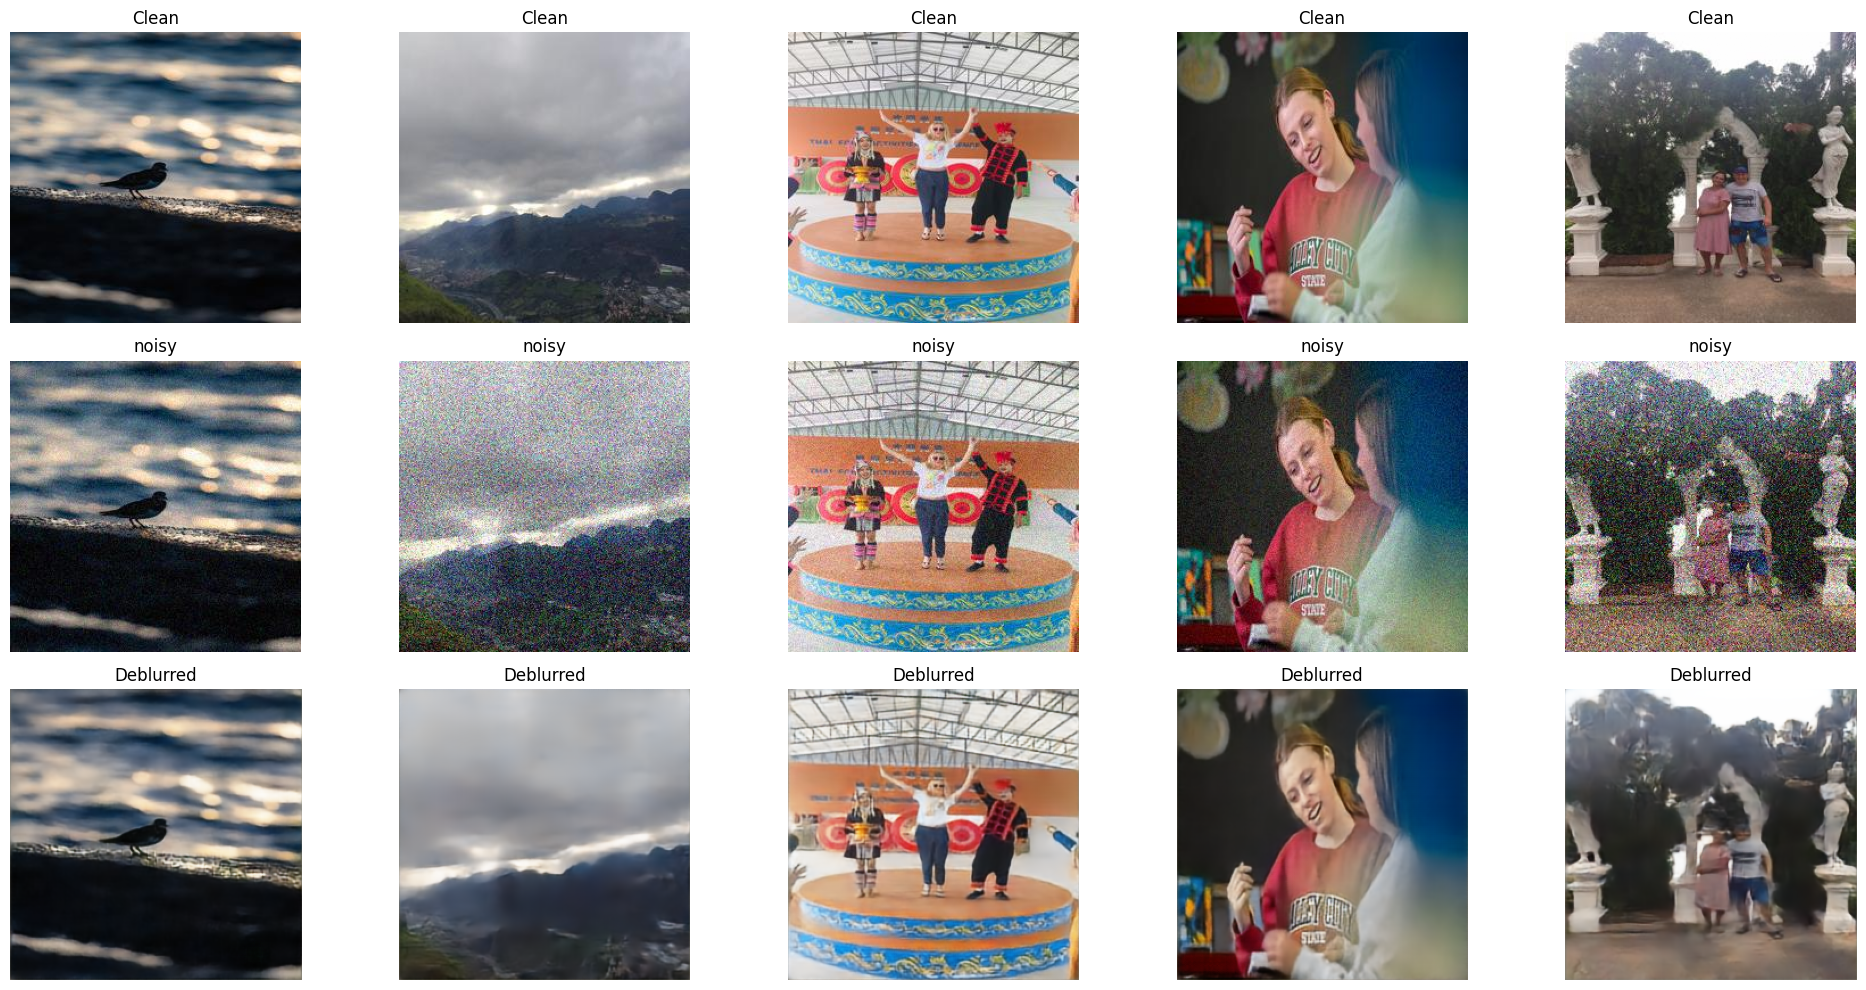

In [ ]:
# Chargement des images de test
test_gen = ImagePairGenerator(
    noisy_dir=BASE_DIR + '/test/noisy',
    clean_dir=BASE_DIR + '/test/clean',
    batch_size=16,
    target_size=IMAGE_SIZE
)

# Évaluation du modèle
test_loss, test_psnr, test_ssim = model.evaluate(test_gen)
print(f"Test Loss: {test_loss}, Test PSNR: {test_psnr}, Test SSIM: {test_ssim}")

# Fonction pour afficher les images débruitées
def display_deblurred_images(model, test_gen, num_images=5):
    # On charge les images de test
    batch_noisy, batch_clean = test_gen[0]  # On récupère un batch (noisy et clean)

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        noisy_image = batch_noisy[i]
        clean_image = batch_clean[i]

        # Prédire l'image débruitée
        noisy_input = np.expand_dims(noisy_image, axis=0)  # Ajouter la dimension du batch
        deblurred_image = model.predict(noisy_input)[0]

        # Affichage
        plt.subplot(3, num_images, i + 1)
        plt.imshow(clean_image)
        plt.title("Clean")
        plt.axis("off")

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy_image)
        plt.title("noisy")
        plt.axis("off")

        plt.subplot(3, num_images, i + 1 +2 * num_images)
        plt.imshow(deblurred_image)
        plt.title("Deblurred")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Affichage des images débruitées
display_deblurred_images(model, test_gen)

